In [117]:
# import the required libraries
import matplotlib.pyplot as plt
import numpy as np

In [118]:
eps = {'a_x': 0.4, 'a_y': 0.5}
gl_bounds = {'x': [0, 1], 'y': [0, 1]} # global bounds
true_coords = {'x': 0.6, 'y': 0.4}

# lines stored as [p_start, p_end] = [[x_st, y_st], [x_end, y_end]]
x1, y1, x2, y2 = 0.8, 0.3, 0.38, 0.9
lines = np.array([[[0, y1], [x1, 1]], [[1, y2], [x2, 0]]])
unavail_segs = {'x': np.empty((0, 2)), 'y': np.empty((0, 2))} # new forbidden areas will be stored here

In [119]:
def is_point_in_halfplane(point, p_st, p_end):
    # each line defines a half-plane of impossible worlds
    # this function checks if point is in that half-plane
    cross_pr = np.cross(p_end - p_st, point - p_st)
    if cross_pr > 0: # the line itself does not count
        return True, cross_pr
    return False, cross_pr

def intersect_halfplane_with_square(line, gl_bounds):
    # find initial impossible worlds
    p_st, p_end = np.array(line)
    included_corners = []
    for x in gl_bounds['x']:
        for y in gl_bounds['y']:
            to_include, cross_pr = is_point_in_halfplane(np.array([x, y]), p_st, p_end)
            if to_include:
                included_corners.append([cross_pr, [x, y]])
    included_corners.sort(reverse=True)
    x_, y_ = [p_st[0], p_end[0]], [p_st[1], p_end[1]]
    for _, corner in included_corners:
        x_.append(corner[0])
        y_.append(corner[1])
    return x_, y_

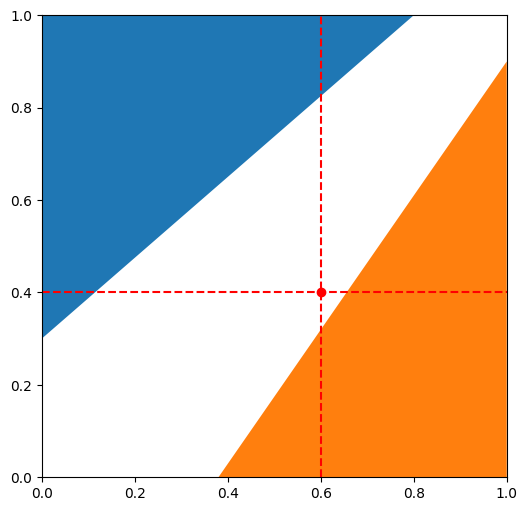

In [120]:
# square 1 x 1
def draw(fig, ax, lines, unavail_segs, true_coords, gl_bounds):
    for line in lines:
        x_, y_ = intersect_halfplane_with_square(line, gl_bounds)
        ax.fill(x_, y_)
    # draw all of the removed areas
    for axis in ['x', 'y']:
        other_axis = 'x' if axis == 'y' else 'y'
        num_segs = unavail_segs[axis].shape[0]
        for i in range(num_segs):
            x_ = [unavail_segs[axis][i, 0], unavail_segs[axis][i, 1], unavail_segs[axis][i, 1], unavail_segs[axis][i, 0]]
            y_ = [gl_bounds[other_axis][0], gl_bounds[other_axis][0], gl_bounds[other_axis][1], gl_bounds[other_axis][1]]
            if axis == 'y':
                x_, y_ = y_, x_
            ax.fill(x_, y_)
    ax.plot(true_coords['x'], true_coords['y'], marker='o', color='red')
    ax.vlines(true_coords['x'], gl_bounds['y'][0], gl_bounds['y'][1], colors='red', linestyle='dashed')
    ax.hlines(true_coords['y'], gl_bounds['x'][0], gl_bounds['x'][1], colors='red', linestyle='dashed')

    ax.set(xlim=gl_bounds['x'], ylim=gl_bounds['y'])


fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 6))
draw(fig, ax, lines, unavail_segs, true_coords, gl_bounds)

In [121]:
def intersect_segments(line1, line2):
    # https://stackoverflow.com/a/565282
    p1, p2 = line1[0], line2[0]
    vec1, vec2 = line1[1] - line1[0], line2[1] - line2[0]
    vec_cross_pr = np.cross(vec1, vec2)
    if vec_cross_pr == 0: # < 1e-6
        if np.cross(p2 - p1, vec1) == 0: # < 1e-6
            t0 = np.dot(p2 - p1, vec1) / np.dot(vec1, vec1)
            t1 = t0 + np.dot(vec2, vec1) / np.dot(vec1, vec1)
            if t1 < t0:
                t0, t1 = t1, t0
            if t0 <= 1 and t1 >= 0: # [t0, t1] instersects [0, 1]
                return "overlapping"
            else:
                None
        else:
            return None
    else:
        coef1 = np.cross(p2 - p1, vec2) / vec_cross_pr
        coef2 = np.cross(p2 - p1, vec1) / vec_cross_pr
        if 0 <= coef1 and coef1 <= 1 and 0 <= coef2 and coef2 <= 1:
            return p1 + coef1 * vec1
        return None

def check_possibility(point, lines):
    # check if the world is possible (limited to initial half-planes)
    num_lines = lines.shape[0]
    for i in range(num_lines):
        line = lines[i]
        if is_point_in_halfplane(point, line[0], line[1])[0]:
            return False
    return True

def segment_diff(st_coord, end_coord, sorted_segs):
    # we assume that all of the sorted_segs are disjointed
    if sorted_segs.shape[0] == 0:
        return st_coord, end_coord
    sorted_segs_coords = sorted_segs[:, 0]
    st_id = np.searchsorted(sorted_segs_coords, st_coord, side='left')
    end_id = np.searchsorted(sorted_segs_coords, end_coord, side='right')
    if end_id == 0 or st_id == sorted_segs.shape[0]:
        return st_coord, end_coord
    ## double check this section
    if sorted_segs[st_id, 1] == 1: # end of segment
        st_coord = sorted_segs[st_id, 0]
    if sorted_segs[end_id - 1, 1] == 0: # start of segment
        end_coord = sorted_segs[end_id - 1, 0]
    return st_coord, end_coord

def free_segment_length(coord, axis, lines, unavail_segs, gl_bounds):
    # axis == 'x' means we want to find the length of vertical segment,
    # i.e. x coordinate is fixed and vice versa
    true_line = np.array([[gl_bounds['x'][0], coord], [gl_bounds['x'][1], coord]]) if axis == 'y' \
                    else np.array([[coord, gl_bounds['y'][0]], [coord, gl_bounds['y'][1]]])
    inter_line1 = intersect_segments(true_line, lines[0])
    inter_line2 = intersect_segments(true_line, lines[1])

    if inter_line1 is None and inter_line2 is None:
        st_point, end_point = true_line
    elif inter_line1 is not None and inter_line2 is not None:
        st_point, end_point = inter_line1, inter_line2 # order doesn't matter
    else:
        st_point = inter_line2 if inter_line1 is None else inter_line1
        end_point = true_line[0] if check_possibility(true_line[0], lines) else true_line[1]

    sort_axis = 0 if axis == 'y' else 1
    if st_point[sort_axis] > end_point[sort_axis]:
        st_point, end_point = end_point, st_point

    st_coord, end_coord = segment_diff(st_point[sort_axis], end_point[sort_axis], \
                                       unavail_segs[axis])
    st_point[sort_axis] = st_coord
    end_point[sort_axis] = end_coord

    return np.linalg.norm(end_point - st_point)

In [122]:
# test segment_diff

In [123]:
def add_unavail_seg(unavail_segs, axis, seg):
    # we're keeping the segments disjoint and sorted
    # change happens in-place
    st_id = np.searchsorted(unavail_segs[axis][:, 0], seg[0], side='right')
    end_id = np.searchsorted(unavail_segs[axis][:, 1], seg[1], side='left')
    if st_id - 1 == end_id:
        # segment we're trying to add lies fully inside of an already existing segment
        return
    del_st_id, del_end_id = None, None
    add_st_coord, add_end_coord = None, None
    add_id = None
    if st_id != 0 and seg[0] <= unavail_segs[axis][st_id - 1, 1]:
        # the beginning of our segment lies inside of another segment
        add_st_coord = unavail_segs[axis][st_id - 1, 0]
        del_st_id = st_id - 1
        add_id = st_id - 1
    else:
        add_st_coord = seg[0]
        del_st_id = st_id
        add_id = st_id
    if end_id < unavail_segs[axis].shape[0] and seg[1] >= unavail_segs[axis][end_id, 0]:
        # the ending of our segment lies inside of another segment
        add_end_coord = unavail_segs[axis][end_id, 1]
        del_end_id = end_id
    else:
        add_end_coord = seg[1]
        del_end_id = end_id - 1

    unavail_segs[axis] = np.delete(unavail_segs[axis], np.s_[del_st_id:del_end_id + 1], axis=0)
    unavail_segs[axis] = np.insert(unavail_segs[axis], add_id, [add_st_coord, add_end_coord], axis=0)

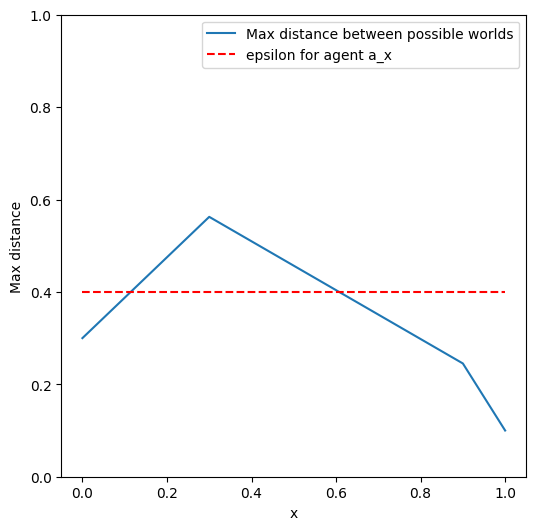

In [124]:
def plot_data(cois, axis, lines, unavail_segs, gl_bounds):
    # return max lengths for points coordinates in axis
    x = []
    y = []
    for coi in cois:
        x.append(coi)
        y.append(free_segment_length(coi, axis, lines, unavail_segs, gl_bounds))
    return x, y

cois = np.unique(lines[:, 0])
axis = 'x'

x, y = plot_data(cois, axis, lines, unavail_segs, gl_bounds)

def draw_plot(fig, ax, x, y, axis, eps, gl_bounds):
    other_axis = 'x' if axis == 'y' else 'y'
    ax.plot(x, y, label='Max distance between possible worlds')
    ax.hlines(eps['a_' + axis], 0, 1, colors='red', linestyle='dashed', label='epsilon for agent a_' + axis)
    ax.set_ylim(gl_bounds[other_axis][0], gl_bounds[other_axis][1])
    ax.set_xlabel(axis)
    ax.set_ylabel('Max distance')
    ax.legend()

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 6))
draw_plot(fig, ax, x, y, axis, eps, gl_bounds)
plt.show()

[[0.0, 0.11428571428571435], [0.6072426937738244, 1.0]]

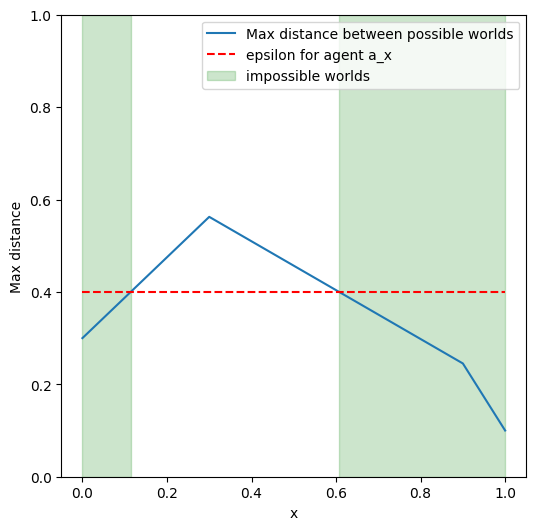

In [125]:
def draw_impossible_worlds(fig, ax, piecewise_x, piecewise_y, eps, gl_bounds, axis, remove_small):
    # need to add impossible segments
    imposs_x = []
    tmp = []

    for i in range(len(piecewise_x)):
        x = piecewise_x[i]
        y = piecewise_y[i]
        for j in range(len(x) - 1):
            inter_point = intersect_segments(np.array([[x[j], y[j]], [x[j + 1], y[j + 1]]]), \
                                            np.array([[gl_bounds[axis][0], eps['a_' + axis]], [gl_bounds[axis][1], eps['a_' + axis]]]))
            if (remove_small and y[j] < eps['a_' + axis]) or ((not remove_small) and y[j] >= eps['a_' + axis]):
                tmp.append(x[j])
            elif tmp:
                imposs_x.append([tmp[0], tmp[-1]])
                tmp = []
            if not inter_point is None:
                tmp.append(inter_point[0])

        if (remove_small and y[-1] < eps['a_' + axis]) or (not remove_small and y[-1] >= eps['a_' + axis]):
            tmp.append(x[-1])
        if tmp:
            imposs_x.append([tmp[0], tmp[-1]])

    draw_plot(fig, ax, x, y, axis, eps, gl_bounds)
    label = 'impossible worlds'

    for seg in imposs_x:
        ax.fill_between(seg, gl_bounds[axis][0], gl_bounds[axis][1], color='green', alpha=0.2, label=label)
        label = None
    ax.legend()
    return imposs_x


fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 6))
draw_impossible_worlds(fig, ax, [x], [y], eps, gl_bounds, 'x', True)

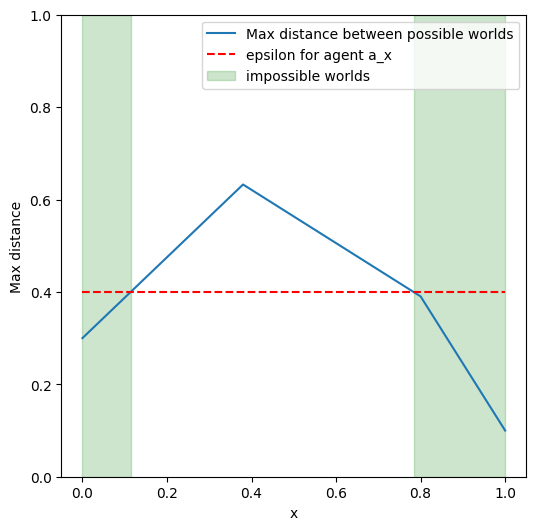

In [126]:
def remove_impossible_areas(lines, unavail_segs, axis, remove_small, eps, gl_bounds):
    other_axis = 'x' if axis == 'y' else 'y'
    sort_axis = 0 if axis == 'x' else 1
    cois = lines[:, :, sort_axis] # coordinates of interest
    cois = cois.flatten()
    add_coords = [gl_bounds[axis][0], gl_bounds[axis][1]]
    # calculate intersections with impossible areas
    num_segs_oa = unavail_segs[other_axis].shape[0]
    for i in range(num_segs_oa):
        seg = unavail_segs[other_axis][i]
        tmp_line = np.array([[seg[0], gl_bounds['y'][0]], [seg[1], gl_bounds['y'][1]]]) if axis == 'x' else \
                    np.array([[gl_bounds['x'][0], seg[0]], [gl_bounds['x'][1], seg[1]]])
        inter_line1 = intersect_segments(lines[0], tmp_line)
        inter_line2 = intersect_segments(lines[1], tmp_line)
        if inter_line1 is not None:
            add_coords.append(inter_line1[sort_axis])
        if inter_line2 is not None:
            add_coords.append(inter_line2[sort_axis])

    cois = np.concatenate((cois, add_coords), axis=0)
    cois = np.unique(cois) # np.unique returns sorted array

    x, y = plot_data(cois, axis, lines, unavail_segs, gl_bounds)

    # remove unavail_segs[axis]
    num_segs = unavail_segs[axis].shape[0]
    piecewise_x = []
    piecewise_y = []
    last_id = 0
    tmp_x, tmp_y = [], []
    for i in range(num_segs):
        seg = unavail_segs[axis][i]
        st_id = np.searchsorted(x, seg[0], side='right')
        end_id = np.searchsorted(x, seg[1], side='left')
        piecewise_x.append(tmp_x + x[last_id:st_id])
        piecewise_y.append(tmp_y + y[last_id:st_id])
        piecewise_x[-1].append(seg[0])
        piecewise_y[-1].append(y[st_id - 1] + (y[st_id] - y[st_id - 1]) * (seg[0] - x[st_id - 1]) / (x[st_id] - x[st_id - 1]))

        tmp_x = [seg[1]]
        tmp_y = [y[end_id - 1] + (y[end_id] - y[end_id - 1]) * (seg[1] - x[end_id - 1]) / (x[end_id] - x[end_id - 1])]
        last_id = end_id
    piecewise_x.append(tmp_x + x[last_id:])
    piecewise_y.append(tmp_y + y[last_id:])
    if piecewise_x[0][0] == piecewise_x[0][1]:
        piecewise_x = piecewise_x[1:]
        piecewise_y = piecewise_y[1:]
    if piecewise_x[-1][0] == piecewise_x[-1][1]:
        piecewise_x = piecewise_x[:-1]
        piecewise_y = piecewise_y[:-1]

    fig, ax = plt.subplots(figsize=(6, 6))
    imposs_x = draw_impossible_worlds(fig, ax, piecewise_x, piecewise_y, eps, gl_bounds, axis, remove_small)
    plt.show()

    for seg in imposs_x:
        add_unavail_seg(unavail_segs, axis, seg)

remove_impossible_areas(lines, unavail_segs, 'x', True, eps, gl_bounds)
unavail_segs = {'x': np.empty((0, 2)), 'y': np.empty((0, 2))}

In [127]:
def run_process(eps, gl_bounds, true_coords, lines, unavail_segs):
    axis, other_axis = 'x', 'y'
    has_changed_prev, has_changed = True, True
    step = 1

    while has_changed_prev or has_changed:
        remove_small = False if free_segment_length(true_coords[axis], axis, lines, unavail_segs, gl_bounds) < eps['a_' + axis] \
                        else True
        if remove_small:
            print('agent a_' + axis + ' knows')
        else:
            print('agent a_' + axis + ' doesn\'t know')
        has_changed_prev = has_changed
        has_changed = remove_impossible_areas(lines, unavail_segs, axis, remove_small, eps, gl_bounds)
        axis, other_axis = other_axis, axis
        step += 1
    return step

agent a_x knows


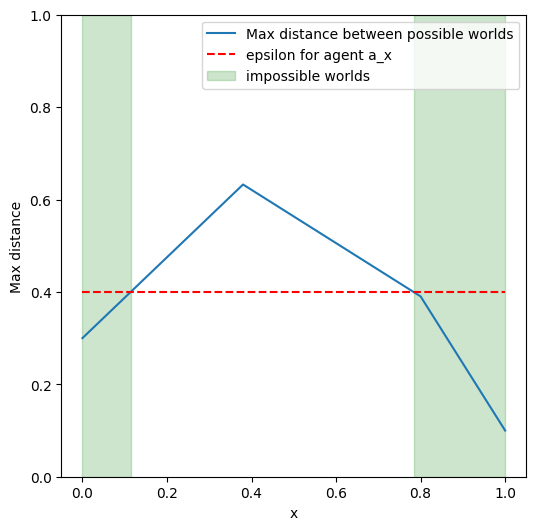

agent a_y knows


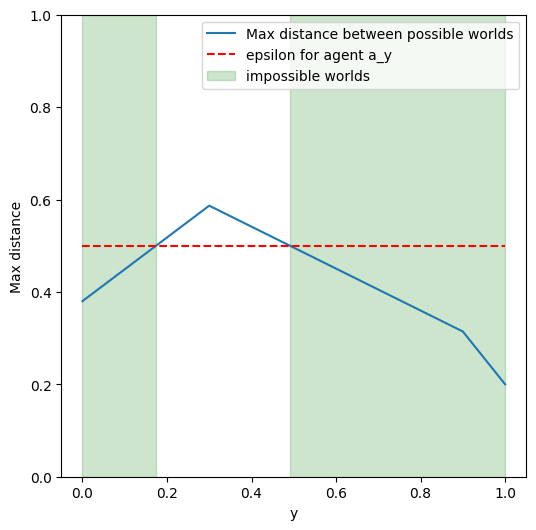

3

In [128]:
eps = {'a_x': 0.4, 'a_y': 0.5}
gl_bounds = {'x': [0, 1], 'y': [0, 1]} # global bounds
true_coords = {'x': 0.6, 'y': 0.4}

# lines stored as [p_start, p_end] = [[x_st, y_st], [x_end, y_end]]
x1, y1, x2, y2 = 0.8, 0.3, 0.38, 0.9
lines = np.array([[[0, y1], [x1, 1]], [[1, y2], [x2, 0]]])
unavail_segs = {'x': np.empty((0, 2)), 'y': np.empty((0, 2))} # new forbidden areas will be stored here

run_process(eps, gl_bounds, true_coords, lines, unavail_segs)